# Technical 

In [139]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy import optimize
import random
from functools import partial
from multiprocessing import Pool
import time

# Chemicals 

In [140]:
speciesNames=["NO", "NO2", "O2", "O3", "O3P"];
ratesNames = ["y1","y2","y3"]


getElemInd = {speciesNames[l]: l for l in range(len(speciesNames))}
getRateInd = {ratesNames[l]: l for l in range(len(ratesNames))}

nSpecies = len(speciesNames)
nRates = len(ratesNames)

constantSpecies = np.zeros((nSpecies))

constantSpecies[getElemInd['O2']]=1

constantSpeciesList=[]
constantSpeciesList.append('O2')



## Default values

In [141]:
Temp=288.15;

pres=101325;

cair=pres/1.3807e-17/Temp;

cfactor = 2.550000e+10;

concO2 = 0.21*cair;

# tOffset=12*3600

tOffset=0


#molec/cm^{3} 


initState=np.zeros((nSpecies))

# initState[getElemInd["O2"]] = concO2;

# initState[getElemInd["O2"]] = concO2;

# initState[getElemInd["O3"]] = 40*cfactor;

initState[getElemInd["O3P"]] = 0;
initState[getElemInd["NO"]] = 1.3*10**8;
initState[getElemInd["NO2"]] = 5.0*10**11;
initState[getElemInd["O3"]] = 8.0*10**11;
initState[getElemInd["O2"]] = concO2;





srcDef=np.zeros((nSpecies))
srcDef[getElemInd["NO"]] =  10**6;


# production destruction

In [142]:
def prod(prevState,rates):
    
    expFactor = np.zeros((nSpecies))
    
    
    
    NOPrev = prevState[0];
    NO2Prev = prevState[1];
    O2Prev = prevState[2];
    O3Prev = prevState[3];
    O3PPrev = prevState[4];
    
    y1 = rates[0];
    y2 = rates[1];
    y3 = rates[2];
    
#     print(rates)
    
#     print([NOPrev,NO2Prev,O3Prev,O3PPrev])
    
    NOExp = NO2Prev*y1;
    NO2Exp = NOPrev*O3Prev*y3;
    O2Exp = NOPrev*O3Prev*y3;
    O3Exp = O2Prev*O3PPrev*y2;
    O3PExp = NO2Prev*y1;
    
#     print([O2Prev,O3PPrev,y2,O2Prev*O3PPrev*y2])
    

    
    expFactor[0] = NOExp;
    expFactor[1] = NO2Exp;
    expFactor[2] = O2Exp;
    expFactor[3] = O3Exp;
    expFactor[4] = O3PExp;

    return expFactor;



def destr(prevState,rates):
    
    expFactor = np.zeros((nSpecies))
    
    NOPrev = prevState[0];
    NO2Prev = prevState[1];
    O2Prev = prevState[2];
    O3Prev = prevState[3];
    O3PPrev = prevState[4];

    y1 = rates[0];
    y2 = rates[1];
    y3 = rates[2];
    
    NOExp = O3Prev*y3;
    NO2Exp = y1;
    O2Exp = O3PPrev*y2;
    O3Exp = NOPrev*y3;
    O3PExp = O2Prev*y2;
    
    expFactor[0] = NOExp;
    expFactor[1] = NO2Exp;
    expFactor[2] = O2Exp;
    expFactor[3] = O3Exp;
    expFactor[4] = O3PExp;

    return expFactor;

In [143]:
def prodCalc(prevState,rates):
    
    res=prod(prevState,rates);
    
    for spec in constantSpeciesList:
        res[getElemInd[spec]]=0
    
    return res

def destCalc(prevState,rates):
    
    res=destr(prevState,rates);
    
    for spec in constantSpeciesList:
        res[getElemInd[spec]]=0
    
    return res    

# Make rates

In [144]:
def makeRates(t):
    
    rate = np.zeros((nRates))
    
    th=(t+tOffset)/3600;

    curHourDecimal = th-24*ma.floor(th/24);


    if ((curHourDecimal > 4) and (curHourDecimal <20)):       
        rate[0]=(1e-5)*ma.exp(7.0*pow(ma.sin((ma.pi/16)*(curHourDecimal-4)),0.2));
    else:
        rate[0]=1e-40;

    rate[1]=(1e+5)/concO2;
    rate[2]=1e-16;
    
    return rate
    

# Discrete analytic scheme

In [145]:
minExpFactor=10**(-2)

maxExpFactor=10**(2)


def L(dt,P):
    if (dt*P < minExpFactor) : 
        return 1-P*dt;
    elif (dt*P > maxExpFactor) :
        return 0;
    else:
        return np.exp(-P*dt);


def LVecFun(dt,P):
    return np.array([L(dt,Pin) for Pin in P])

    
    
def G(dt,P):
    if( dt*P < minExpFactor ) :
        return dt;
    elif (dt*P > maxExpFactor) :
        return 1/P;
    else:
        return ((np.exp(-P*dt)-1)/(-P*dt))*dt;


def GVecFun(dt,P):
    return np.array([G(dt,Pin) for Pin in P])    
    


def step_QSSA(P,Pi,t,ratesFunction,fi,src,dt):
    Pcur=P(fi,ratesFunction(t))
    Picur=Pi(fi,ratesFunction(t))
#     prodCalc(prevState,rates)
    LVec=LVecFun(dt,Pcur)
    GVec=GVecFun(dt,Pcur)
    
    return LVec*fi+GVec*(Picur+src)


def step_QSSA_staticRates(P,Pi,t,ratesFunction,fi,src,dt):
    Pcur=P(fi,ratesFunction)
    Picur=Pi(fi,ratesFunction)
#     prodCalc(prevState,rates)
    LVec=LVecFun(dt,Pcur)
    GVec=GVecFun(dt,Pcur)
    
    return LVec*fi+GVec*(Picur+src)
    

In [146]:
def makeDirectTrajectory(Tall,Nt,P,Pi,ratesFunction,initState,src):
    
    dt=Tall/Nt
    
    traj=[]
    
    t=0
    state=initState.copy()
    
    traj.append([t,state])
    
    for j in range(Nt):
        t = t+dt
        state=step_QSSA(P,Pi,t,ratesFunction,state,src,dt)
        traj.append([t,state])
    
    return traj

def makeDirectTrajectorystaticRates(DAW,Nt,P,Pi,ratesFunction,initState,src):
    
    dt=(DAW[1]-DAW[0])/Nt
    
    traj=[]
    
    t=DAW[0]
    state=initState.copy()
    
    traj.append([t,state])
    #print(state)
    for j in range(Nt):
        t = t+dt
        state=step_QSSA_staticRates(P,Pi,t,ratesFunction,state,src,dt)
        traj.append([t,state])
    
    return traj



# tmpTraj=makeDirectTrajectorystaticRates

In [153]:
tmpTraj=makeDirectTrajectorystaticRates(6*24*3600,2*6*1000,destCalc,prodCalc,makeRates,initState,srcDef)

TypeError: 'function' object is not subscriptable

q=[initstate($N_{c}$),rates($N_{y}$),src([$N_{c}$)]

# Data Assimilation Project

$q \in Q$


Direct(Dom,q,v)
Inverse(Dom,q,v,I,cfg)
InverseProblemSolver(Inverse)
OpEqSolve(nIn,nOut)

fun()

grad()

discrep()

sensop()

Обратная на интервале (окно усвоения, модель, q и v)
Алгоритм перемещения окон усвоения - результат решения на нем использовать для постановки на следующем окне
Неопределенность q: (начальное данное, коэффициенты), (начальное, коэффициенты, источник)
парметр v

Отдельно описать алгоритмы типа 3DVAR
-3DVAR
-Nudjing
-фильтры калмана

Алгоритмы типа 4DVAR
-


DAWs=[]
DAW.append()


For DAW in DAWs:
	V = 
	I = obtainMeasurementData(DAW)
[q,fi]=SolveIP(DAW,v,I);
IPSols.append()


In [147]:
cfg={}

dt=30

cfg["dt"]=30

Nc=5
Ny=3

T=24*3600
nDAW=10
Nt=2*6*1000

cfg["T"]=T
cfg["nDAW"]=nDAW
cfg["Nc"]=Nc

cfg["P"]=destCalc
cfg["Pi"]=prodCalc

singleDAWLength=T/nDAW

DAWs=[]
for i in range(nDAW):
    DAWs.append([i*singleDAWLength,(i+1)*singleDAWLength])

## Generate exact solution

In [148]:
gloablDomain=[0,T]

coeffNoon=makeRates(12*3600)

qExact={"init":initState,"coeff":coeffNoon}

v={"src":np.zeros(Nc)}

In [149]:
qExact

{'init': array([1.30000000e+08, 5.00000000e+11, 5.34832707e+18, 8.00000000e+11,
        0.00000000e+00]),
 'coeff': array([1.09663316e-02, 1.86974354e-14, 1.00000000e-16])}

In [150]:
def makeDirectTrajectorystaticRates(DAW,Nt,P,Pi,ratesFunction,initState,src):
    
    dt=(DAW[1]-DAW[0])/Nt
    
    traj=[]
    
    t=DAW[0]
    state=initState.copy()
    
    traj.append([t,state])
    
    for j in range(Nt):
        t = t+dt
        state=step_QSSA_staticRates(P,Pi,t,ratesFunction,state,src,dt)
        traj.append([t,state])
    
    return traj


In [151]:
# solves direct problem
# DAW - data assimialtion window in form [begin,end]
# dt - time step
# q - uncertainty function
# v - set parameters
# cfg - configuration dictionary
# return
# trajectory in form [[timeStep \in DAW,stateFunction]]

def solveDirectProblem(DAW,dt,q,v,cfg):
    
    initState=q["init"]
    coeff=q["coeff"]
    src=v["src"]
    
    T = DAW[1]-DAW[0]
    
    Nt=int(T/dt)
        
    traj=[]
    
    t=DAW[0]
    state=initState.copy()
    
    traj.append([t,state])
    
    for j in range(Nt):
        t = t+dt
        state=step_QSSA_staticRates(cfg["P"],cfg["Pi"],t,coeff,state,src,dt)
        traj.append([t,state])
    
    return traj



In [152]:
exactTraj=solveDirectProblem([0,T],dt,qExact,v,cfg)

# measurement data

Химия, Биология, Экономика (концентрации в точках, усреденения за какой-то интревал, функции),

концентрации в точках:
(момент времени, элемент, значение, погрешность)

In [153]:
measDataDesc=[]
LmeasNames=['NO','NO2']   # measureable species

measInterval=20*60 # interval between measurements

measTimeDomain = np.arange(0,T,measInterval) 

measError={}
measError['NO']=1
measError['NO2']=1

for t in measTimeDomain:
    for specName in LmeasNames: 
        measDataDesc.append([t,specName,measError[specName]])

In [154]:
# finds the index of the nearest point to t in tDom  

def nearestIndex(tDom,t):
        
    return np.argmin([(x-t)**2 for x in tDom])
    

## operation H

In [155]:
# extract values of traj corresponding to measDataDesc
# measDataDesc has the form [t,specName,measError]

def H(measDataDesc,traj):
    
    tDom=[tD[0] for tD in traj]
    
    measVector=[]
    
    for meas in measDataDesc:
        nearestInd = nearestIndex(tDom,meas[0])
        
        measVector.append([[meas[0],meas[1],meas[2]],traj[nearestInd][1][getElemInd[meas[1]]]])
        
    return measVector
            

In [156]:
# extracts the subset of measDataDesc that is within DAW
# DAW - data assimialtion window in form [begin,end]

def extractMeasDAW(DAW,measDataDesc):
    return list(filter(lambda x: (x[0]>=DAW[0]) and (x[0]<=DAW[1]), measDataDesc))

# inverse problem solver

In [157]:
# encodeUncert encodes uncertainty to a vector
# decodeUncert ecodes vector to a uncertainty

def encodeUncert(q):  
    return np.concatenate((q["init"], q["coeff"]), axis=None)
    
def decodeUncert(x):
    q={}
    q["init"]=x[0:Nc]
    q["coeff"]=x[Nc:]
    
    return q.copy()

In [59]:
# encode decode test
print(['qExact',qExact])
qExactEnc=encodeUncert(qExact)
qDec=decodeUncert(qExactEnc)
print(['qExDec',qDec])

['qExact', {'init': array([1.30000000e+08, 5.00000000e+11, 5.34832707e+18, 8.00000000e+11,
       0.00000000e+00]), 'coeff': array([1.09663316e-02, 1.86974354e-14, 1.00000000e-16])}]
['qExDec', {'init': array([1.30000000e+08, 5.00000000e+11, 5.34832707e+18, 8.00000000e+11,
       0.00000000e+00]), 'coeff': array([1.09663316e-02, 1.86974354e-14, 1.00000000e-16])}]


In [158]:
# solves inverse problem 
# DAW - data assimialtion window in form [begin,end]
# dt - time step
# qInit - initial approximation to qFinal
# v - set parameters
# measDataArray 
# cfg - configuration dictionary
# return
# [trajFi,qFinal] 
# qFinal - results of the inverse problem solution algorithm
# trajFi in form [[timeStep \in DAW,stateFunction]] corresponding to qFinal


# returns [trajFi,q]  
#

def solveInverseProblem(DAW,dt,qInit,v,measDataArray,cfg):

    T=DAW[1]-DAW[0]
    
    # cost function definition x
    

    
    
    qMin={}
    qMin["init"] =  qExact["init"]/2;
    qMin["coeff"] = qExact["coeff"]/2;

    xMinIP =  np.array(encodeUncert(qMin))
    
    qMax={}
    qMax["init"] = 2*qExact["init"]
    qMax["coeff"] = 2*qExact["coeff"]
    
    xMaxIP = np.array(encodeUncert(qMax))
    

    
#     bounds = Bounds(xMin, xMax)
    
    
    xInit=np.array(encodeUncert(qInit))
    
    measDataDesc = [el[0] for el in measDataArray]  
    mesRes= np.array([el[1] for el in measDataArray])

   
  
    
#     print(['mesRes',mesRes])
    
    def fun(x):
        qFun=decodeUncert(x);
        funSol=solveDirectProblem(DAW,dt,qFun,v,cfg)
        modeledData = H(measDataDesc,funSol)
        modeledMeasurements = np.array([el[1] for el in modeledData])
#         print(['modeledMeasurements',modeledMeasurements])
        returnValue=(LA.norm(mesRes-modeledMeasurements))**2
        print([x,returnValue])
        return returnValue
   
#     bounds = [xMin, xMax]
    
#     bounds = Bounds(xMin, xMax)
    
    
    xExact=np.array(encodeUncert(qExact))
    
    print(['xMax',xMaxIP])
    
    print(['xExact',xExact])
    
    print(['xMin',xMinIP])
    
    print(['exact:',fun(xExact)])
    
    
    bounds = [(xMinIP[l],xMaxIP[l]) for l in range(len(xMinIP))]
    
#     res = minimize.shgo(fun, bounds)
    
    
#     optionsMinim={}
#     optionsMinim["maxiter"]=1
    
    
    
#     res = optimize.shgo(fun, bounds)
    
    res = optimize.differential_evolution(fun, bounds)


#  res = optimize.shgo(fun, bounds,options=optionsMinim)
    
#     res = minimize(fun,x0=xInit, bounds=bounds, method='nelder-mead')
    
#     res = minimize(fun, xInit, method='nelder-mead',
#                options={'xatol': 1e-8, 'disp': True},bounds=bounds)
    
    
#     res = minimize(fun, xInit, method='trust-constr',
#                options={'disp': True},bounds=bounds)
    
    print(res) 
    
    
    xFinal=res.x
#     xFinal=xInit

    
    qFinal = decodeUncert(xFinal)
    trajFi = solveDirectProblem(DAW,dt,qFinal,v,cfg)
    
    return [trajFi,qFinal]     

In [159]:
T=1*3600

gloablDomain=[0,T]
coeffNoon=makeRates(12*3600)
qExact={"init":initState,"coeff":coeffNoon}
v={"src":np.zeros(Nc)}

dt=3600/(100)

exactTraj=solveDirectProblem(gloablDomain,dt,qExact,v,cfg)

measDataDesc=[]
LmeasNames=['NO','NO2']   # measureable species

measInterval=20*60 # interval between measurements

measTimeDomain = np.arange(0,T,measInterval) 

measError={}
measError['NO']=1
measError['NO2']=1

for t in measTimeDomain:
    for specName in LmeasNames: 
        measDataDesc.append([t,specName,measError[specName]])

exactData=H(measDataDesc,exactTraj)

coeffNight=makeRates(0)

# initStateInit=np.zeros((nSpecies))
qInit={"init":initState,"coeff":coeffNight}

initTraj=solveDirectProblem(gloablDomain,dt,qInit,v,cfg)

initData=H(measDataDesc,initTraj)


# TODO

In [78]:
#the algorithm with no bounds produced negative values of the recation rates and iniatial concentartions.
# TODO add constraints to the positive sols
# TODO plot several trajectories on a single plot with legends

# data assimilation cycle

In [70]:
globalSols=[]
IPSols=[]

for DAW in DAWs:
    V = obtainV(IPSols)
    I = obtainMeasurementData(DAW)
    [q,fi]=SolveIP(DAW,v,I,cfg);
    IPSols.append([q,fi])
    [globalQ,gloablFi] = obtainGlobalSol(q,fi)     # процедура прогнозирования - несколько вариантов прогнозирования
    globalSols.append([globalQ,globalFi])
    

NameError: name 'obtainV' is not defined

# Partical filter

In [160]:
def despirsion1(vecIn):
    vecDesp=np.zeros(len(vecIn))
    for i in range(len(vecIn)):
        for k in range(80):
            if vecIn[i]//10**(k-40)<10 and vecIn[i]//10**(k-40)>0:
                #vecDesp[i]=10**k-40
                vecDesp[i]=k-40
                break
    return vecDesp

In [161]:
def randomUniform(a,b):
    c=random.uniform(a, b)
    return c

In [162]:
def vectorRandom(vecIn,Np,despirsion):
    
    statenew=np.zeros((Np,len(vecIn)))
    despirsionnew=despirsion(vecIn)
    
    
#     #возмущения проблемного
#     for i in range(Np):
#         for j in range(len(vecIn)):
#             if vecIn[j]//10**(-40)<10:
#                 statenew[i][j]=vecIn[j]+ 10**randomUniform(-40,-3)
#             else:
#                 statenew[i][j]=vecIn[j]+random.gauss(0,10**despirsionnew[j])
#             if (statenew[i][j]<=0):
#                 statenew[i][j]=abs(statenew[i][j])

    #просто гаусс близки к начальным            
    for i in range(Np):
        for j in range(len(vecIn)):
            statenew[i][j]=vecIn[j]+random.gauss(0,10**despirsionnew[j])
            if (statenew[i][j]<=0):
                statenew[i][j]=abs(statenew[i][j])                
    
#     #сильный разброс всех
#     for i in range(Np):
#         for j in range(len(vecIn)):
#             statenew[i][j]=vecIn[j]+random.gauss(0,10**randomUniform(despirsionnew[j]-20,despirsionnew[j]+20))
#             if (statenew[i][j]<=0):
#                 statenew[i][j]=abs(statenew[i][j])                
                

    return statenew


In [163]:
def vectorRandom1(vecIn,Np,despirsion):
    
    statenew=np.zeros((Np,len(vecIn)))
    despirsionnew=despirsion(vecIn)
    
    for i in range(Np):
        for j in range(len(vecIn)):
            statenew[i][j]=vecIn[j]+random.gauss(0,10**(despirsionnew[j]))
            if (statenew[i][j]<=0):
                statenew[i][j]=abs(statenew[i][j])
    return statenew

In [2282]:
vecIn=[4589,1e-40]
vectorRandom(vecIn,6,despirsion1)

array([[4.82549836e+03, 1.21556879e-15],
       [2.75964599e+03, 2.22200981e-20],
       [5.70641731e+03, 8.70796019e-33],
       [5.75970111e+03, 4.98687589e-06],
       [5.81509110e+03, 2.68225155e-05],
       [4.85343688e+03, 2.05194772e-15]])

## qRandom

In [164]:
def qRandom(qIn,Np,qDespirsion):
    
    initState=qIn["init"]
    rates=qIn["coeff"]
    
    statenew=vectorRandom(initState,Np,despirsion1)
    ratesnew=vectorRandom(rates,Np,despirsion1)
    qEnsambel=[]
    
    for i in range(Np):
        #print("ratesnew[i]",ratesnew[i])
        qEnsambel.append({"init":statenew[i],"coeff":ratesnew[i]})
        #qEnsambel.append({"init":initState,"coeff":ratesnew[i]})
        #qEnsambel.append({"init":statenew[i],"coeff":rates})
    return qEnsambel


## makeDirectTrajectorystaticRatesEnsambel

In [165]:
def randomRandint(a,b):
    c=random.randint(a,b)
    return c

In [166]:
def makeDirectTrajectorystaticRatesEnsambel(DAW,Nt,P,Pi,qEnsambel,src):
    
    #makeDirectTrajectorystaticRates(Tall,Nt,P,Pi,ratesFunction,initState,src)
    
    dt=(DAW[1]-DAW[0])/Nt
    
    trajEnsambel=[]
    
    t=0
    k=0
    for l in range(len(qEnsambel)):
    
        initState=qEnsambel[l]["init"]
#         rates=qEnsambel[l]["coeff"]
        if DAW[0] < 4*3600:
            rates=qEnsambel[l]["coeff"]
        else:
            a=randomRandint(1,1000)
            if a<1000:
            #rates=makeRates(DAW[1])
                rates=qEnsambel[l]["coeff"]
            else:
                k=k+1
                rates=qEnsambel[l]["coeff"]
                rates1=vectorRandom(makeRates(DAW[1]-(DAW[1]-DAW[0])/2),1,despirsion1)
                rates[0]=rates1[0][0]
        trajEnsambel.append(makeDirectTrajectorystaticRates(DAW,Nt,P,Pi,rates,initState,src))
        
        #print(initState)
    print(k)
    
    return trajEnsambel

In [167]:
def makeDirectTrajectoryParall(inArg,DAW,Nt,P,Pi,src):

    initState=inArg[0];
    rates=inArg[1];

    return makeDirectTrajectorystaticRates(DAW,Nt,P,Pi,rates,initState,src)


In [168]:
def makeDirectTrajectorystaticRatesEnsambelParall(DAW,Nt,P,Pi,qEnsambel,src):
    
    #makeDirectTrajectorystaticRates(Tall,Nt,P,Pi,ratesFunction,initState,src)
    
    nCores=72
    
    dt=(DAW[1]-DAW[0])/Nt
    
    trajEnsambelArg=[]
    
    t=0
    
    for l in range(len(qEnsambel)):
    
        initState=qEnsambel[l]["init"]
#         rates=qEnsambel[l]["coeff"]
        if DAW[0] < 4*3600:
            rates=qEnsambel[l]["coeff"]
        else:
            a=randomRandint(1,100)
            if a<=0:
            #rates=makeRates(DAW[1])
                rates=qEnsambel[l]["coeff"]
            else:
                rates=qEnsambel[l]["coeff"]
                rates1=vectorRandom(makeRates(DAW[1]-(DAW[1]-DAW[0])/2),1,despirsion1)
                rates[0]=rates1[0][0]
        trajEnsambelArg.append([initState, rates])
        
        #print(initState)
    makeDirectTrajectoryParallArg = partial(makeDirectTrajectoryParall, DAW=DAW,Nt=Nt,P=P,Pi=Pi,src=src)

    p = Pool(nCores)


    trajEnsambel=p.map(makeDirectTrajectoryParallArg,trajEnsambelArg)
    p.close()
    p.join()
    

    return trajEnsambel #порядок rates и initstate в makeDirectTrajectoryParall и makeDirectTrajectoryParall?

## normalization

In [169]:
def normalization(weight):
    S=np.sum(weight)
    weight=weight/S
    return weight

## weight

In [170]:
def misfit2weight(inArg):
#     return ma.exp(-(inArg))
    return 1/(inArg+10**(-15))
#     return inArg

In [171]:
def weight(trajEnsambelIn,measDataArray):
    
    measDataDesc = [el[0] for el in measDataArray]  
    mesRes= np.array([el[1] for el in measDataArray])
    weight=np.zeros(Np)
    
    for l in range(Np):
        modeledData = H(measDataDesc,trajEnsambelIn[l])
#         print(modeledData)
        modeledMeasurements = np.array([el[1] for el in modeledData])
#         print(['modeledMeasurements',modeledMeasurements])
        returnValue=((LA.norm(mesRes-modeledMeasurements))**2)/(LA.norm(mesRes))**2
        weight[l]=misfit2weight(returnValue)

    
    return weight


In [172]:
def HParall(inArg):
    measDataDesc=inArg[0];
    trajEnsambelIn=inArg[1];
    
    return H(measDataDesc,trajEnsambelIn)

In [173]:
def returnValueParall(inArg):
    mesRes=inArg[0];
    modeledMeasurements=inArg[1];
    returnValue=((LA.norm(mesRes-modeledMeasurements))**2)/(LA.norm(mesRes))**2
    return misfit2weight(returnValue)

In [174]:
def weightParall(trajEnsambelIn,measDataArray):
    
    nCores=72
    
    measDataDesc = [el[0] for el in measDataArray]  
    mesRes= np.array([el[1] for el in measDataArray])
    modeledDataArg=[]
    
    for l in range(Np):
        modeledDataArg.append([measDataDesc,trajEnsambelIn[l]])
    
    HArg = partial(HParall)

    p = Pool(nCores)

    modeledData=p.map(HArg,modeledDataArg)
    p.close()
    p.join()
    
#     modeledMeasurements=[]
#     for l in range(Np):
#         modeledMeasurements.append([el[1] for el in modeledData[l]])
#     print(modeledMeasurements)
    
    
    weightArg=[]
    for l in range(Np):
        weightArg.append([mesRes,[el[1] for el in modeledData[l]]])
    
    returnValueArg = partial(returnValueParall)

    q = Pool(nCores)

    weight=q.map(returnValueArg,weightArg)
    q.close()
    q.join()
    
    return weight

## resampling

In [175]:
def resampling(weight):
    index = random.randint(0, Np-1)
    betta = 0
    VVV=[]
    INDEX=[] 
    
    for s in range(Np):
        betta = betta + random.uniform(0, 2*weight.max())
        while betta > weight[index]:
            betta = betta - weight[index]
            index = (index + 1)%Np # индекс изменяется в цикле от 0 до N
        VVV.append(weight[index])
        INDEX.append(index)
    
    for s in range(Np):
        weight[s]=VVV[s]
        
    return [weight,INDEX]

In [176]:
def resampling1(weight):
    c=[]
    sum=0
    for i in range(Np):
        if i==0:
            c.append([0,weight[0],weight[0]])
        else:
            sum=sum+weight[i-1]
            c.append([sum+10**(-20),sum+weight[i],weight[i]])
    return C(c)

In [177]:
def C(c):
    INDEX=[]
    VVV=[]
    for i in range(Np):
        a=random.uniform(0,1)
        for j in range(Np):
            if c[j][0]<=a and a<=c[j][1]:
                INDEX.append(j)
                VVV.append(c[j][2])
    return [VVV,INDEX]

In [178]:
def resamplingParall(inArg):
    weight=inArg
    return resampling(weight)

In [179]:
def resamplingParallParall(weight):
    nCores=72
    
    
        
        
    resamplingArg = partial(resamplingParall)
    p = Pool(nCores)

    weight=p.map(resamplingArg,weightArg)
    p.close()
    p.join()
    print(weight)
    return weight

## particalFilterAnalisis

In [180]:
def particalFilterAnalisis(qEnsambelIn,trajEnsambelIn,measDataArray):
    
# взвешивание
    tic = time.perf_counter()
    VV=weightParall(trajEnsambelIn,measDataArray)
#     VV=weight(trajEnsambelIn,measDataArray)
    toc = time.perf_counter()
    print(f"Вычисление веса заняло {toc - tic:0.4f} секунд")
# нормализация 
    tic1 = time.perf_counter()
    VV=normalization(VV)
    toc1 = time.perf_counter()
    print(f"Вычисление нормализации заняло {toc1 - tic1:0.4f} секунд")
# отсев/передискретизация
    tic2 = time.perf_counter()
#     resamplingArray=resampling(VV)
    resamplingArray=resampling1(VV)
#     resamplingArray=resamplingParallParall(VV,Np)
    VV=resamplingArray[0]
    INDEX=resamplingArray[1]
    toc2 = time.perf_counter()
    print(f"Вычисление отсева заняло {toc2 - tic2:0.4f} секунд")
# нормализация    
    VV=normalization(VV) 
   
    #print(trajEnsambelIn[0]) #[частица][момент времени][(0-массив времён,1-массив концентраций)]
    #print(trajEnsambelIn[0][0][1][0])
    
# новый ансамбль
    tic3 = time.perf_counter()
    qEnsambelOut=[]
    Nt = len(trajEnsambelIn[0]) 
    Nc = len(speciesNames)  
    qEnsambelOutNew=np.zeros((Np,Nc))
    
    for s in range(Np):
        qEnsambelOutNew[s]=vectorRandom1(trajEnsambelIn[INDEX[s]][-1][1],1,despirsion1)
        #print("qEnsambelOutNew[s]",qEnsambelOutNew[s],"trajEnsambelIn[INDEX[s]][-1][1]",trajEnsambelIn[INDEX[s]][-1][1])
    
    for s in range(Np):
#         qEnsambelOut.append({"init":trajEnsambelIn[INDEX[s]][-1][1],"coeff":qEnsambelIn[INDEX[s]]["coeff"]})
        qEnsambelOut.append({"init":qEnsambelOutNew[s],"coeff":qEnsambelIn[INDEX[s]]["coeff"]})
    toc3 = time.perf_counter()
    print(f"Вычисление нового ансамбля заняло {toc3 - tic3:0.4f} секунд")     
# траектория
    tic4 = time.perf_counter()
    trajEnsambelInit=np.zeros((Np,Nt,Nc))
    trajEnsambelSum=[]
    
    for s in range(Np):
        for t in range(Nt):
            for i in range(Nc):
                trajEnsambelInit[s][t][i]=trajEnsambelIn[INDEX[s]][t][1][i]*VV[s]
    
    for t in range(Nt):
        trajEnsambelSum.append([trajEnsambelIn[0][t][0],np.zeros(Nc)])
     
    for s in range(Np):
        for t in range(Nt):
            for i in range(len(speciesNames)):
                trajEnsambelSum[t][1][i]=0
    
    for t in range(Nt):
        for i in range(Nc):
            for s in range(Np):
                 trajEnsambelSum[t][1][i]=trajEnsambelSum[t][1][i]+trajEnsambelInit[s][t][i]
    toc4 = time.perf_counter()
    print(f"Вычисление траектории заняло {toc4 - tic4:0.4f} секунд")
# отсортированные веса
    tic5 = time.perf_counter()
    VVsort=[]
    
    for s in range(Np):
        VVsort.append(VV[s])
    
    VVsort.sort()
    plt.plot(VVsort)
    plt.grid()
    plt.xlabel('Количество частиц', fontsize=14)
    plt.ylabel('Вес', fontsize=14)
    plt.show()    
    #print("VVsort", VVsort)
    toc5 = time.perf_counter()
    print(f"Вычисление сортировка заняло {toc5 - tic5:0.4f} секунд")
    
    return [trajEnsambelSum, qEnsambelOut]

## cfg

In [181]:
cfg={}

dt=30

cfg["dt"]=30

Nc=len(speciesNames)
Ny=3
Np=10
Nt=2*1*300
T=1*6*3600

nDAW=6
cfg["Nt"]=Nt
cfg["T"]=T
cfg["nDAW"]=nDAW
cfg["Nc"]=Nc
cfg["Np"]=Np
cfg["NtDAW"]=int(Nt/nDAW)

cfg["P"]=destCalc
cfg["Pi"]=prodCalc
cfg["src"]=srcDef

singleDAWLength=T/nDAW

DAWs=[]
for i in range(nDAW):
    DAWs.append([i*singleDAWLength,(i+1)*singleDAWLength])

measDataDesc=[]
    



LmeasNames=["NO", "NO2", "O2", "O3", "O3P"]   # measureable species
# LmeasNames=["NO", "NO2"]
LmeasNames=["O3"]
measInterval=20*60 # interval between measurements
measTimeDomain = np.arange(0,T,measInterval) 

measError={}
# measError['NO']=0
# measError['NO2']=0
# measError['O2']=0
measError['O3']=0
# measError['O3P']=0

for t in measTimeDomain:
    for specName in LmeasNames: 
        measDataDesc.append([t,specName,measError[specName]])
        
exactTraj=makeDirectTrajectory(T,Nt,destCalc,prodCalc,makeRates,initState,srcDef)
exactdata=H(measDataDesc,exactTraj)
#print(initState)

## ANALIS

[0.0, 84000.0]
Вычисление траекторий заняло 1.0208 секунд
Вычисление измерений заняло 6.7303 секунд
Вычисление веса заняло 3.6037 секунд
Вычисление нормализации заняло 0.0001 секунд
Вычисление отсева заняло 0.0001 секунд
Вычисление нового ансамбля заняло 0.0053 секунд
Вычисление траектории заняло 0.5249 секунд


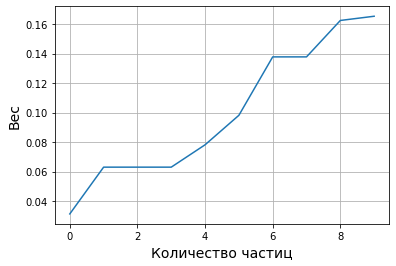

Вычисление сортировка заняло 0.4064 секунд
Вычисление окна заняло 12.2929 секунд
[84000.0, 168000.0]
Вычисление траекторий заняло 1.6090 секунд
Вычисление измерений заняло 6.7410 секунд
Вычисление веса заняло 3.6499 секунд
Вычисление нормализации заняло 0.0002 секунд
Вычисление отсева заняло 0.0001 секунд
Вычисление нового ансамбля заняло 0.0061 секунд
Вычисление траектории заняло 0.6535 секунд


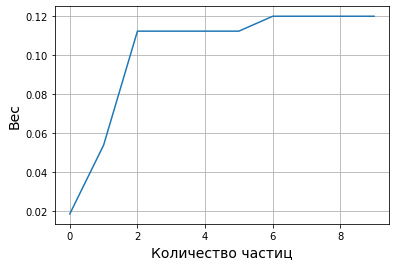

Вычисление сортировка заняло 0.2345 секунд
Вычисление окна заняло 12.8963 секунд
[168000.0, 252000.0]
Вычисление траекторий заняло 1.0131 секунд
Вычисление измерений заняло 6.6708 секунд
Вычисление веса заняло 4.4688 секунд
Вычисление нормализации заняло 0.0001 секунд
Вычисление отсева заняло 0.0001 секунд
Вычисление нового ансамбля заняло 0.0064 секунд
Вычисление траектории заняло 0.5305 секунд


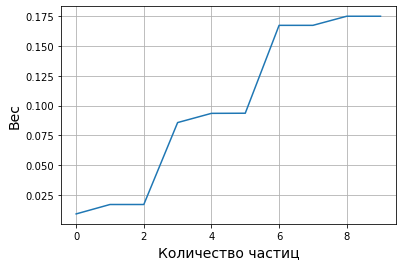

Вычисление сортировка заняло 0.1854 секунд
Вычисление окна заняло 12.8763 секунд
[252000.0, 336000.0]
Вычисление траекторий заняло 1.2501 секунд
Вычисление измерений заняло 6.7582 секунд
Вычисление веса заняло 3.6029 секунд
Вычисление нормализации заняло 0.0001 секунд
Вычисление отсева заняло 0.0001 секунд
Вычисление нового ансамбля заняло 0.0061 секунд
Вычисление траектории заняло 0.7705 секунд


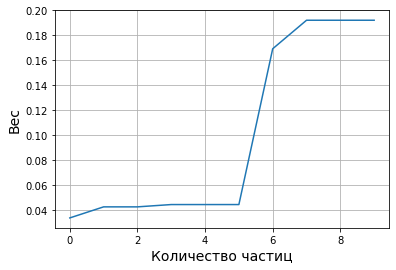

Вычисление сортировка заняло 0.1875 секунд
Вычисление окна заняло 12.5763 секунд
[336000.0, 420000.0]
Вычисление траекторий заняло 1.5295 секунд
Вычисление измерений заняло 7.2295 секунд
Вычисление веса заняло 4.2848 секунд
Вычисление нормализации заняло 0.0001 секунд
Вычисление отсева заняло 0.0001 секунд
Вычисление нового ансамбля заняло 0.0060 секунд
Вычисление траектории заняло 0.7209 секунд


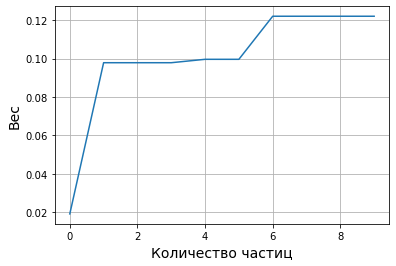

Вычисление сортировка заняло 0.2998 секунд
Вычисление окна заняло 14.0715 секунд
[420000.0, 504000.0]
Вычисление траекторий заняло 1.4206 секунд
Вычисление измерений заняло 6.1977 секунд
Вычисление веса заняло 4.8484 секунд
Вычисление нормализации заняло 0.0001 секунд
Вычисление отсева заняло 0.0001 секунд
Вычисление нового ансамбля заняло 0.0062 секунд
Вычисление траектории заняло 0.8538 секунд


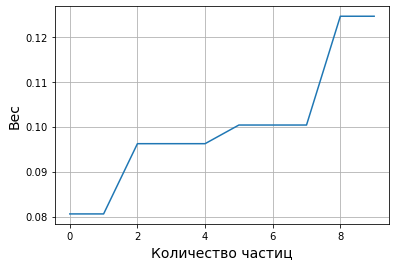

Вычисление сортировка заняло 0.1685 секунд
Вычисление окна заняло 13.4962 секунд
Вычисление общее заняло 1.3035 минут


In [45]:
tic = time.perf_counter()
coeffNight=makeRates(0)

qInitDAW ={"init":initState,"coeff":coeffNight}


qEnsambelInit=qRandom(qInitDAW,Np,despirsion1)

qEnsambelIn=qEnsambelInit

traj = []
trajEnsambel1 = []
for DAW in DAWs:
    print(DAW)
    tic1 = time.perf_counter()
    trajEnsambel=makeDirectTrajectorystaticRatesEnsambelParall(DAW,cfg["NtDAW"],cfg["P"],cfg["Pi"],qEnsambelIn,cfg["src"])
#     trajEnsambel=makeDirectTrajectorystaticRatesEnsambel(DAW,cfg["NtDAW"],cfg["P"],cfg["Pi"],qEnsambelIn,cfg["src"])
    trajEnsambel1 += trajEnsambel
    toc2 = time.perf_counter()
    print(f"Вычисление траекторий заняло {toc2 - tic1:0.4f} секунд")
    tic3 = time.perf_counter()
    dawData=H(extractMeasDAW(DAW,measDataDesc),exactTraj)
    toc3 = time.perf_counter()
    print(f"Вычисление измерений заняло {toc3 - tic3:0.4f} секунд")
    [trajFiTest, qEnsambelOut]=particalFilterAnalisis(qEnsambelIn,trajEnsambel,dawData)
    qEnsambelIn=qEnsambelOut
    traj += trajFiTest
    toc1 = time.perf_counter()
    print(f"Вычисление окна заняло {toc1 - tic1:0.4f} секунд")
    #print(trajFiTest)
toc = time.perf_counter()
print(f"Вычисление общее заняло {(toc - tic)/60:0.4f} минут")       

In [271]:
def tDomMulti(Traj):
    tDom = []
    nDAW = 6
    Np=10
    Nt=101
    for j in range (nDAW):
        for k in range(Nt-1):
            tDom.append(trajEnsambel1[j*Np][k][0])
    tDom.append(trajEnsambel1[nDAW*Np-1][Nt-1][0])
    return tDom

In [272]:
def yDomMulti(Traj):
    nDAW = 6
    Np=10
    Nt=101
    yDom1 = np.zeros((Np,nDAW*(Nt-1)+1))
    yDom1 = []
    yDom = []
    for i in range (Np):
        for j in range (nDAW):
            for k in range(Nt-1):
#                 yDom.append(trajEnsambel1[i*j+i][k][1])
#                 yDom[i][j*k+k]=trajEnsambel1[i*j+i][k][1]
                yDom.append(trajEnsambel1[Np*j+i][k][1])
        yDom.append(trajEnsambel1[Np*j+i][Nt-1][1])
    print(len(yDom))
    print(len(trajEnsambel1))
    return yDom

## plotTraj

In [182]:
def plotTraj(Traj,Traj1):
    tDom=[tD[0] for tD in Traj]
    tDom1=[tD[0] for tD in Traj1]
    for spec in speciesNames:
        yDom=[tD[1][getElemInd[spec]] for tD in Traj]
        yDom1=[tD[1][getElemInd[spec]] for tD in Traj1]
        plt.plot(tDom,yDom, label='Точное')
        plt.plot(tDom1,yDom1, label='Экспериментальное')
        plt.grid()
        plt.legend()
        plt.xlabel('Время', fontsize=14)
        plt.ylabel('Концентрация', fontsize=14)
        plt.title(spec)
#         plt.colorbar()
        plt.show()


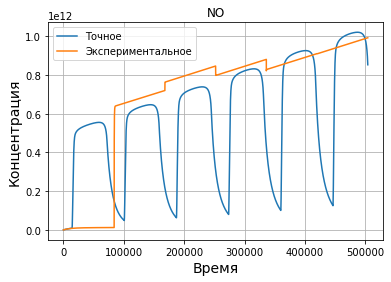

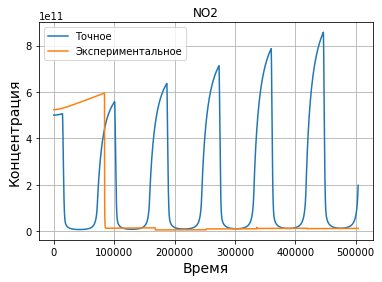

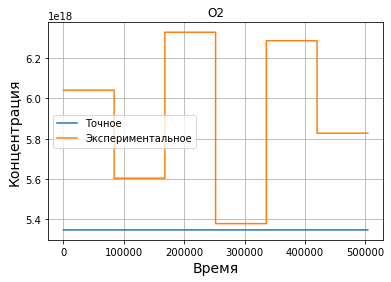

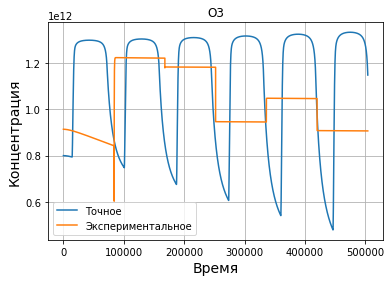

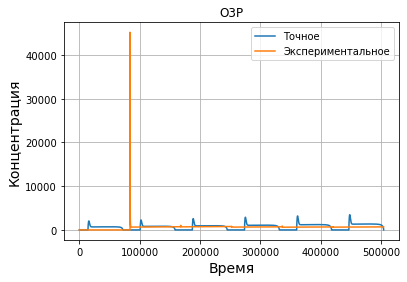

In [47]:
plotTraj(exactTraj,traj)

In [48]:
def plotTraj1(Traj):
    tDom=[tD[0] for tD in Traj]
    for spec in speciesNames:
        yDom=[tD[1][getElemInd[spec]] for tD in Traj]
        plt.plot(tDom,yDom)
        plt.xlabel('Время', fontsize=14)
        plt.ylabel('Концентрация', fontsize=14)
        plt.title(spec)
#         plt.colorbar()
        plt.show()

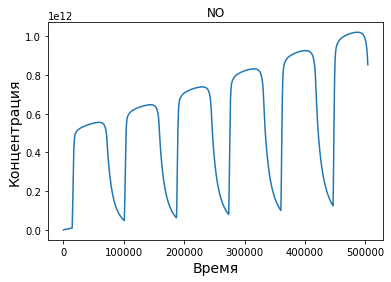

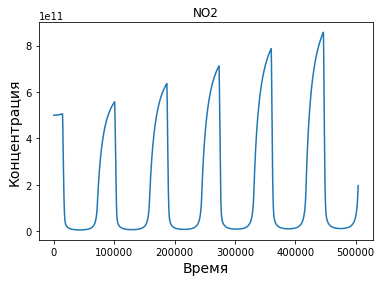

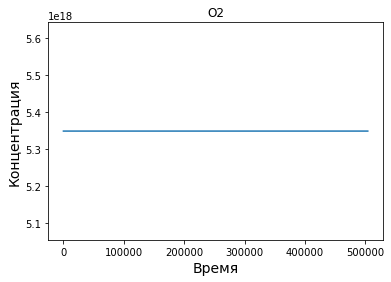

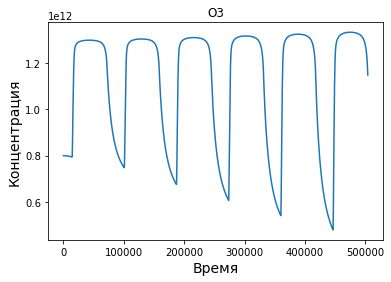

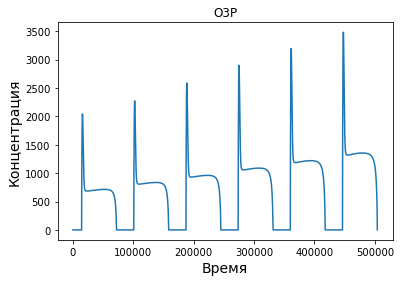

In [49]:
plotTraj1(exactTraj)

In [277]:
def plotTraj2(Traj,Traj1,Traj2):
    tDom=[tD[0] for tD in Traj]
    tDom1=[tD[0] for tD in Traj1]
    
    nDAW = 6
    Np=10
    Nt=101
    tDom2=tDomMulti(Traj2)
    Y=yDomMulti(Traj2)
    
    for spec in speciesNames:
        yDom=[tD[1][getElemInd[spec]] for tD in Traj]
        yDom1=[tD[1][getElemInd[spec]] for tD in Traj1]
        plt.plot(tDom,yDom, linewidth = 10, label='Точное')
        plt.plot(tDom1,yDom1, linewidth = 10, label='Взвешенное')
        
        YY=[tD[getElemInd[spec]] for tD in Y]
        print(len(YY))
        for i in range(Np):
            yDom2=[]
            for j in range((Nt-1)*nDAW+1):
                yDom2.append(YY[((Nt-1)*nDAW*+1)*i+j])
            plt.plot(tDom2,yDom2)
            plt.xlabel('Время', fontsize=14)
            plt.ylabel('Концентрация', fontsize=14)
        plt.title(spec)
        plt.legend()
#         plt.colorbar()
        plt.show()

6010
60
6010


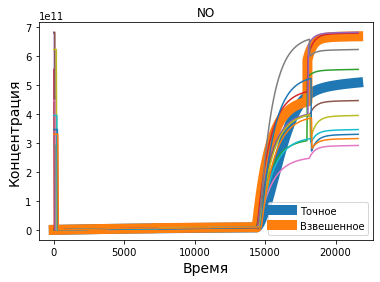

6010


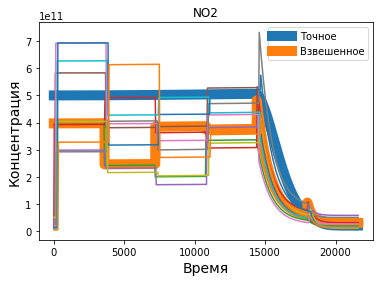

6010


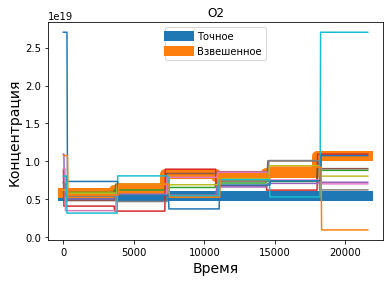

6010


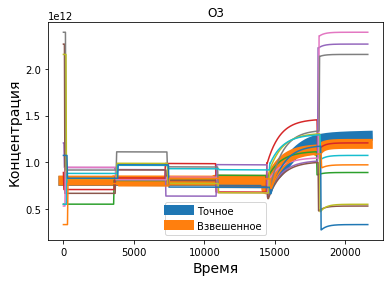

6010


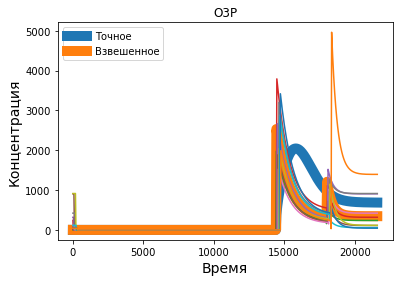

In [278]:
plotTraj2(exactTraj,traj,trajEnsambel1)

In [ ]:
from functools import partial
from multiprocessing import Pool


def makeIllParall(inArg,sensOpData,hInv):

    nSpec=inArg[0];
    i=inArg[1];
    j=inArg[2];

    return ((np.dot(sensOpData[:,nSpec,i,j],np.dot(hInv,sensOpData[:,nSpec,i,j]))))




makeIllCartesParallArg = partial(makeIllCartesParall, sensOpData=sensOpData)

p = Pool(nCores)


cartesRes=p.map(makeIllCartesParallArg,cartesTaks,chunksize=int(len(cartesTaks)/nCores))
p.close()
p.join()
